# Geography permutation test

June 18, 2020 

We would like to determine whether samples collected in the same geographic area share more variants than expected by chance alone. I am imagining the following permutation test: 

1. Select 2 samples at random. Compute the proportion of total variants between them that are shared. Do this a bunch of times. Make a distribution of results. 
2. Select 2 samples from the same geographic area. Repeat. 
3. Finally, compute the fraction of shared variants between transmission pairs. Plot this as a dotted line on this distribution. This can give you a p-value. 

In [101]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

import copy
from scipy.special import binom
import datetime as dt
    
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Read in VCF data and output SNVs to query into a dataframe

In [102]:
def return_list_of_vcfs(vcf_directory):
    vcf_list = []
    for f in glob.glob(vcf_directory + "*intersection.csv"):
        vcf_list.append(f)
    return(vcf_list)

In [103]:
def read_in_intersection_snvs(vcf_list, vcf_directory):
    within_host_df = pd.DataFrame()
    
    for v in vcf_list:
        # pull out sampleid
        sampleid = v.replace(vcf_directory,"").replace("intersection.csv","")
        
        d = pd.read_csv(v, sep="\t")
        d['sampleid'] = sampleid
        within_host_df = within_host_df.append(d)
        
    return(within_host_df)

In [104]:
def separate_snvs_from_frameshift(within_host_df):
    snvs_df = within_host_df[(within_host_df['annotation'] == "missense") | (within_host_df['annotation'] == "synonymous") | (within_host_df['annotation'] == "stop")]
    snvs_df['aa_site'] = snvs_df['aa_chage'].str[3:-3]
    snvs_df['wt_aa'] = snvs_df['aa_chage'].str[0:3]
    snvs_df['mut_aa'] = snvs_df['aa_chage'].str[-3:]
    
    # add in columns for nucleotide changes 
    snvs_df['nt_ref'] = snvs_df['nt_change'].str.split(">",expand=True)[0].str[-1:]
    snvs_df['nt_mut'] = snvs_df['nt_change'].str.split(">",expand=True)[1]
    
    indels_df = within_host_df[(within_host_df['annotation'] == "frameshift") | (within_host_df['annotation'] == "frameshift&stop")]
    return(snvs_df, indels_df)

In [105]:
def read_strain_names_from_csv(strain_names_file):
    strain_names_dict = {}
    
    with open(strain_names_file, "r") as infile: 
        for line in infile:
            if "Sample identifier" not in line:
                tube_number = line.split("\t")[1]
                strain_name = line.split("\t")[0].replace("hCoV-19/","")
                
                # there are 2 sets of tube numbers, some with leading 0s and others without. I am pretty sure we
                # want the ones with leading 0s; there are also some we don't want that have non-numeric tube #s
                if tube_number.isdigit() and tube_number.startswith("0"):
                    strain_names_dict[str(int(tube_number))] = strain_name
                    
    return(strain_names_dict)

In [106]:
def convert_number_to_strain(sampleid, strain_names_dict):
    if sampleid in strain_names_dict:
        strain_name = strain_names_dict[sampleid]
    else:
        strain_name = "unknown"
        print(sampleid)
    return(strain_name)

In [107]:
def add_in_strain_column(df, strain_names_dict):
    temp_df = pd.DataFrame(df)
    strain_name = temp_df['sampleid'].apply(convert_number_to_strain, args=[strain_names_dict])
    #strain_name = temp_df['sampleid'].apply(lambda x: "USA/" + tube_number_conversion[x] + "/2020")
    temp_df["strain_name"] = strain_name
    return(temp_df)

In [108]:
def format_indels(row):
    
    if "dup" in row['nt_change']:
        split_char = "dup"
        variant = row['nt_change'].split(split_char)[1]
        new_value = "-" + str(int(row["POS"])) + variant
    
    elif "del" in row['nt_change']:
        split_char = "del"
        variant = row['nt_change'].split(split_char)[1]
        new_value = str(int(row['POS'])) +  variant + "-"
    
    return(new_value)

In [109]:
def return_indel_type(row):
    
    if "dup" in row['nt_change']:
        type_change = "insertion"
     
    elif "del" in row['nt_change']:
        type_change = "deletion"
    
    return(type_change)

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled).

In [220]:
strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/spreadsheet-with-strain-names.tsv"
strain_names_dict = read_strain_names_from_csv(strain_names_file)

In [221]:
vcf_directory = "/Users/lmoncla/src/ncov-WI-within-host/data/VCFs/"
vcfs = return_list_of_vcfs(vcf_directory)
all_intersection_variants = read_in_intersection_snvs(vcfs, vcf_directory)
all_intersection_variants = add_in_strain_column(all_intersection_variants, strain_names_dict)
snvs_only, indels_only = separate_snvs_from_frameshift(all_intersection_variants)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

In [222]:
# add in a column for the nucleotide mutation so that it is in the same format as the annotation on nextstrain
snvs_only['nuc_muts'] = snvs_only['nt_ref'] + snvs_only["POS"].astype(int).astype(str) + snvs_only['nt_mut']

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [223]:
# add a column with formatted indel that matches nextstrain
indels_only['nuc_muts'] = indels_only.apply(format_indels, axis=1)
indels_only['type_mut'] = indels_only.apply(return_indel_type, axis=1)
indels_only.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,SNP,POS,REF,annotation,gene_x,nt_change,aa_chage,rep1_percent,rep2_percent,%,sampleid,strain_name,nuc_muts,type_mut
0,1,ORF1ab_875dupA_Leu293fs_frameshift,1135.0,G,frameshift,ORF1ab,875dupA,Leu293fs,2.23,1.96,2.095,117,USA/WI-UW-110/2020,-1135A,insertion
3,4,ORF1ab_6435dupT_Leu2146fs_frameshift,6696.0,C,frameshift,ORF1ab,6435dupT,Leu2146fs,6.63,7.57,7.100,117,USA/WI-UW-110/2020,-6696T,insertion
5,8,ORF1ab_10817dupT_Leu3606fs_frameshift,11074.0,C,frameshift,ORF1ab,10817dupT,Leu3606fs,2.67,3.02,2.845,117,USA/WI-UW-110/2020,-11074T,insertion
12,17,ORF1ab_15705dupT_Val5236fs_frameshift,15965.0,G,frameshift,ORF1ab,15705dupT,Val5236fs,6.31,5.98,6.145,117,USA/WI-UW-110/2020,-15965T,insertion
13,18,ORF1ab_18109dupT_Ser6037fs_frameshift,18368.0,G,frameshift,ORF1ab,18109dupT,Ser6037fs,5.92,4.22,5.070,117,USA/WI-UW-110/2020,-18368T,insertion


In [224]:
# Split into only low frequency, here defined as <50%; I don't really want to query the fixed variants here 
low_freq_snvs_only = snvs_only[snvs_only["%"] < 50]
low_freq_indels_only = indels_only[indels_only["%"] < 50]

In [225]:
snvs_to_query = set(low_freq_snvs_only['nuc_muts'])
indels_to_query = set(low_freq_indels_only['nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

59
31
90


## Code up the permutation test

In [226]:
def pick_2_random_numbers(list_to_sample_from):
    
    import random
    selections = random.sample(list_to_sample_from, 2)
    return(selections[0],selections[1])

In [227]:
def compute_shared_variant_proportion(sample1,sample2,df):
    shared_variants = 0
    
    s1_df = df[df['strain_name'] == sample1]
    variants_in_s1 = set(s1_df['nuc_muts'].tolist())
    
    s2_df = df[df['strain_name'] == sample2]
    variants_in_s2 = set(s2_df['nuc_muts'].tolist())
    
    total_variants = len(variants_in_s1) + len(variants_in_s2)
    
    for v in variants_in_s1:
        if v in variants_in_s2:
            shared_variants += 2
            
    proportion_shared = float(shared_variants/total_variants)
            
    return(proportion_shared)

In [228]:
s = low_freq_snvs_only[["strain_name","nuc_muts","%","sampleid"]]
i = low_freq_indels_only[["strain_name","nuc_muts","%","sampleid"]]
combined_df_low_freq = s.append(i)
combined_df_low_freq.head()

,strain_name,nuc_muts,%,sampleid
7,USA/WI-UW-110/2020,A15139C,1.515,117
8,USA/WI-UW-110/2020,C15141A,1.635,117
9,USA/WI-UW-110/2020,G15150T,3.265,117
10,USA/WI-UW-110/2020,G15168A,7.360,117
11,USA/WI-UW-110/2020,C15173A,1.865,117


In [229]:
s = snvs_only[["strain_name","nuc_muts","%","sampleid"]]
i = indels_only[["strain_name","nuc_muts","%","sampleid"]]
combined_df = s.append(i)
combined_df.head()

,strain_name,nuc_muts,%,sampleid
1,USA/WI-UW-110/2020,C3037T,100.000,117
2,USA/WI-UW-110/2020,G3871T,100.000,117
4,USA/WI-UW-110/2020,G9053C,99.920,117
6,USA/WI-UW-110/2020,C14408T,100.000,117
7,USA/WI-UW-110/2020,A15139C,1.515,117


In [230]:
high_freq_snvs_only = snvs_only[snvs_only['%'] >= 50]
low_freq_indels_snvs = low_freq_indels_only.append(low_freq_snvs_only)
all_indels_snvs = snvs_only.append(low_freq_indels_only)  # high freq indels don't exit

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [231]:
df_to_run = snvs_only

In [232]:
# run a bunch of times
proportions = []

for i in range(10000):
    # query all strains
    list_to_query = set(all_intersection_variants['strain_name'].tolist())
    s1,s2 = pick_2_random_numbers(list_to_query)
    
    # with those random pairs of samples, compute the proportion of snvs that are shared
    proportion_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run)
    proportions.append(proportion_variants_shared)

In [233]:
proportions_df = pd.DataFrame(proportions)
proportions_df.columns = ['proportion_shared']
proportions_df.head()

,proportion_shared
0,0.277778
1,0.444444
2,0.518519
3,0.482759
4,0.263158


In [234]:
print(proportions_df.quantile(0.95))
print(proportions_df.quantile(0.5))

proportion_shared    0.769231
Name: 0.95, dtype: float64
proportion_shared    0.5
Name: 0.5, dtype: float64


The putative transmission pairs are: 
1. USA/WI-UW-65/2020 and USA/WI-UW-32/2020  (2 days apart)
2. USA/WI-UW-41/2020 and USA/WI-UW-48/2020 (same day)
3. USA/WI-UW-74/2020 and USA/WI-UW-29/2020 (4 days apart)
4. USA/WI-UW-120/2020 and USA/WI-UW-119/2020 (3 days apart)
5. USA/WI-UW-333/2020 and USA/WI-UW-334/2020 (same day)
6. USA/WI-UW-337/2020 and USA/WI-UW-338/2020 -> I am actually excluding these, because they do not have the same consensus sequence
7. USA/WI-UW-158/2020 and USA/WI-UW-159/2020 and USA/WI-UW-160/2020  (these are all in the same household) -> I am also going to call 158 and 160 true transmission pairs because they have the same consensus sequence, while 159 has 2 additional mutations (158 and 160 isolated same day)

pairs 5 and 6 are from the Milwaukee area, whereas the rest are more from the Madison area

In [235]:
def compute_p_value(shared_proportion, proportions_random_pairs_list):
    count = 0
    for p in proportions_random_pairs_list:
        if p >= shared_proportion:
            count += 1
            
    fraction_more_extreme = count/len(proportions_random_pairs_list)
    return(fraction_more_extreme)

In [236]:
transmission_pairs = [["USA/WI-UW-65/2020","USA/WI-UW-32/2020"],["USA/WI-UW-41/2020","USA/WI-UW-48/2020"],
                      ["USA/WI-UW-74/2020","USA/WI-UW-29/2020"],["USA/WI-UW-120/2020","USA/WI-UW-119/2020"]]
                     #["USA/WI-UW-333/2020","USA/WI-UW-334/2020"],["USA/WI-UW-158/2020","USA/WI-UW-160/2020"]]

shared_fractions = []
for t in transmission_pairs:
    sample1 = t[0]
    sample2 = t[1]
    proportion_variants_shared = compute_shared_variant_proportion(sample1,sample2,df_to_run)
    print(proportion_variants_shared)
    fraction_more_extreme = compute_p_value(proportion_variants_shared, proportions)
    print(fraction_more_extreme)
    shared_fractions.append(proportion_variants_shared)

0.7741935483870968
0.0464
0.7333333333333333
0.076
0.88
0.0128
0.9696969696969697
0.007


In [197]:
pair1_shared = shared_fractions[0]
pair2_shared = shared_fractions[1]
pair3_shared = shared_fractions[2]
pair4_shared = shared_fractions[3]
pair5_shared = shared_fractions[4]
pair6_shared = shared_fractions[5]

In [198]:
shared_fractions_dict = {"pair":["1","2","3", "4", "5", "6"],
                         "fraction_shared":[pair1_shared,pair2_shared,pair3_shared,pair4_shared,pair5_shared,pair6_shared],
                        "y":[2500,2500,2500,2500,2500,2500]}
df2 = pd.DataFrame.from_dict(shared_fractions_dict)
df2

,pair,fraction_shared,y
0,1,1.0,2500
1,2,1.0,2500
2,3,1.0,2500
3,4,1.0,2500
4,5,1.0,2500
5,6,1.0,2500


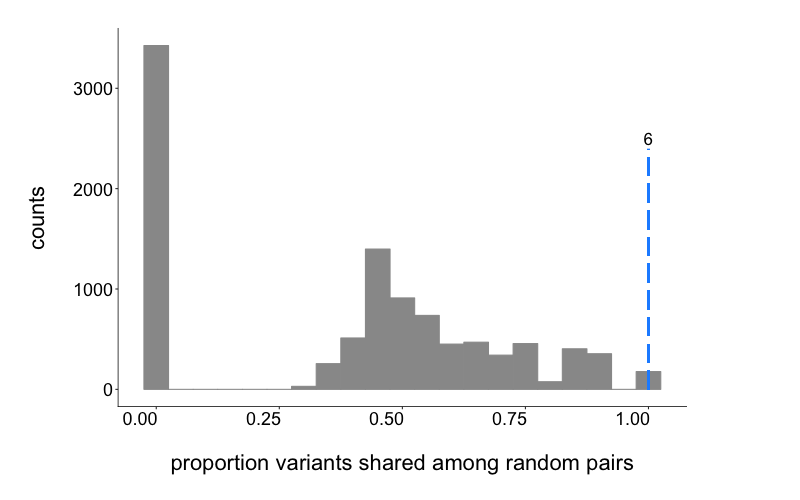

In [199]:
%%R -w 800 -h 500 -u px -i proportions_df,df2,pair1_shared,pair2_shared,pair3_shared,pair4_shared,pair5_shared,pair6_shared  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

y_end = 2400
p <- ggplot(data=proportions_df, aes(x=proportion_shared)) + 
    geom_histogram(binwidth=0.05, color="grey60", fill="grey60")+
    geom_segment(x=pair1_shared,xend=pair1_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair2_shared,xend=pair2_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair3_shared,xend=pair3_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair4_shared,xend=pair4_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair5_shared,xend=pair5_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair6_shared,xend=pair6_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_label(data=df2, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
    labs(x="\nproportion variants shared among random pairs",y="counts\n")+
#     scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
#     scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
#    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.95))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+

ggsave("shared-variants-permutation-test-2020-06-29-high-freq-snvs.pdf", width = 12, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p